In [1]:
import scanpy as sc
import pandas as pd
import torch
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')
import tcr_embedding as tcr

In [6]:
path_model = '../../saved_models/test/poe_haniffa/haniffa_poe_equal_mult3_cond_patient_id_RnaPriority_5_best_rec_model.pt'
#path_model = '../saved_models/test/poe_haniffa/haniffa_poe_equal_cond_patient_id_RnaPriority_2_best_rec_model.pt'
path_data = '../../data/Haniffa/v3_conditional.h5ad'

In [7]:
# load data
data_full = sc.read_h5ad(path_data)
data_train = data_full[data_full.obs['set'] == 'train']
data_val = data_full[data_full.obs['set'] == 'val']

In [5]:
# load model
model_file = torch.load(path_model)
params = model_file['params']
print(params)
trained_model = tcr.utils_training.init_model(params, model_type='PoE', adata=data_full, dataset_name='haniffa', conditional='patient_id')
trained_model.load(path_model)

{'seq_model_arch': 'Transformer', 'seq_model_hyperparams': {'embedding_size': 32, 'num_heads': 4, 'forward_expansion': 4, 'encoding_layers': 2, 'decoding_layers': 2, 'dropout': 0.1, 'max_tcr_length': 27}, 'scRNA_model_arch': 'MLP', 'scRNA_model_hyperparams': {'activation': 'leakyrelu', 'batch_norm': True, 'dropout': 0.2, 'gene_hidden': [800], 'num_layers': 1, 'output_activation': 'linear'}, 'zdim': 50, 'hdim': 800, 'activation': 'leakyrelu', 'dropout': 0.2, 'batch_norm': True, 'shared_hidden': [200]}


In [6]:
trained_model.model.rna_priority = 1

In [7]:
from torch.utils.data import DataLoader, WeightedRandomSampler
def get_latent_space(adata, modality=2):
    metadata = ['full_clustering', 'clonotype']
    pred_datasets, _, _ = trained_model.create_datasets([adata], ['hannifa'], [None], ['tcr_seq'], val_split=0, metadata=metadata)
    pred_dataloader = DataLoader(pred_datasets, batch_size=1024, shuffle=False, collate_fn=None,
                                 num_workers=0)

    
    device = 'cuda'
    zs = []
    with torch.no_grad():
        model = trained_model.model.to(device)
        model.eval()
        for scRNA, tcr_seq, size_factor, name, index, seq_len, metadata_batch, labels, conditional in pred_dataloader:
            scRNA = scRNA.to(device)
            tcr_seq = tcr_seq.to(device)
            conditional = conditional.to(device)

            z, mu, logvar, scRNA_pred, tcr_seq_pred = trained_model.model(scRNA, tcr_seq, seq_len, conditional, -99)
            z = mu

            z = z[modality]  # use joint latent variable
            z = sc.AnnData(z.detach().cpu().numpy())
            z.obs['barcode'] = index
            z.obs['dataset'] = name
            z.obs[metadata] = np.array(metadata_batch).T
            zs.append(z)

    return sc.AnnData.concatenate(*zs)

In [8]:
latent_joint = get_latent_space(data_train, modality=2)

In [9]:
# calculate latent spaces: joint, rna, tcr
latent_joint = get_latent_space(data_train, modality=2)
latent_tcr = get_latent_space(data_train, modality=1)
latent_rna = get_latent_space(data_train, modality=0)

In [10]:
latent_joint.obs['clonotype'] = [x.numpy().tolist() for x in latent_joint.obs['clonotype']]
latent_tcr.obs['clonotype'] = [x.numpy().tolist() for x in latent_tcr.obs['clonotype']]
latent_rna.obs['clonotype'] = [x.numpy().tolist() for x in latent_rna.obs['clonotype']]

In [11]:
print('Joint Space')
print(f'Min:  {np.min(latent_joint.X)}')
print(f'Max:  {np.max(latent_joint.X)}')
print(f'Mean: {np.mean(latent_joint.X)}')
print(f'Var:  {np.var(latent_joint.X)}')

print('RNA Space')
print(f'Min:  {np.min(latent_rna.X)}')
print(f'Max:  {np.max(latent_rna.X)}')
print(f'Mean: {np.mean(latent_rna.X)}')
print(f'Var:  {np.var(latent_rna.X)}')

print('TCR Space')
print(f'Min:  {np.min(latent_tcr.X)}')
print(f'Max:  {np.max(latent_tcr.X)}')
print(f'Mean: {np.mean(latent_tcr.X)}')
print(f'Var:  {np.var(latent_tcr.X)}')

Joint Space
Min:  -29.350082397460938
Max:  31.40985107421875
Mean: -0.09741866588592529
Var:  30.880964279174805
RNA Space
Min:  -31.805206298828125
Max:  17.606220245361328
Mean: -0.0724869817495346
Var:  6.761756896972656
TCR Space
Min:  -29.352615356445312
Max:  31.410152435302734
Mean: -0.0928300991654396
Var:  30.974782943725586


In [12]:
lats = {
    'joint': latent_joint,
    'tcr': latent_tcr,
    'rna': latent_rna
}

In [13]:
latent_joint.shape

(60701, 50)

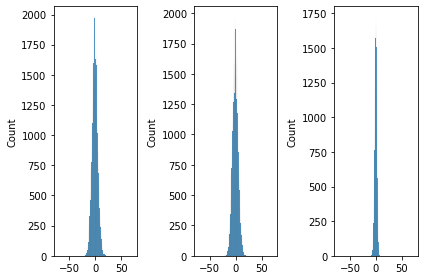

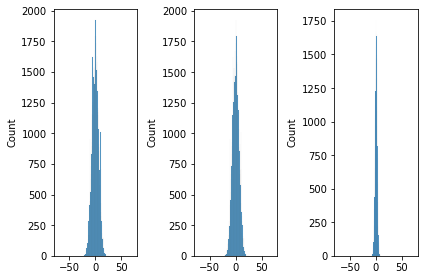

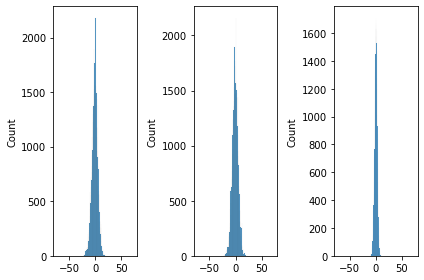

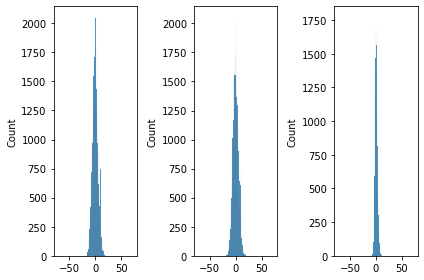

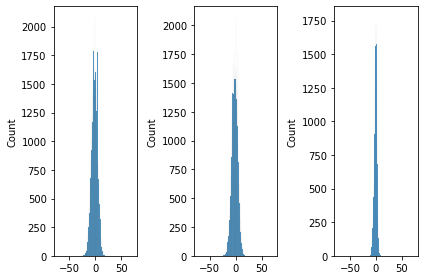

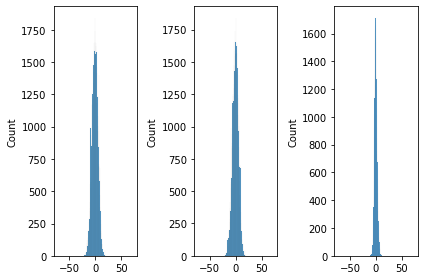

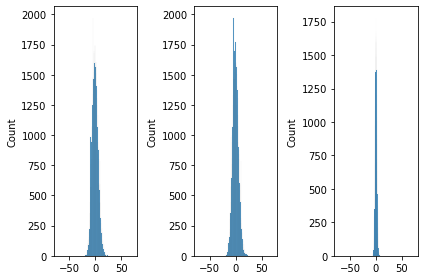

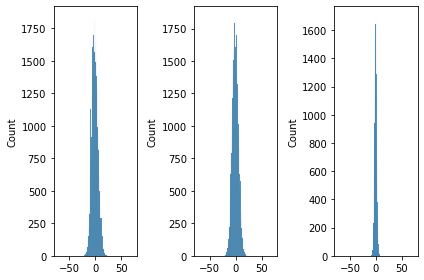

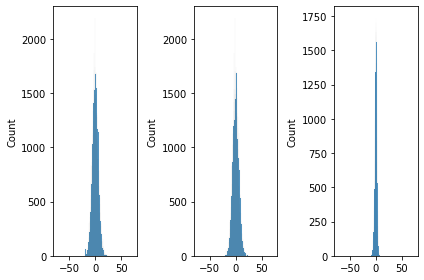

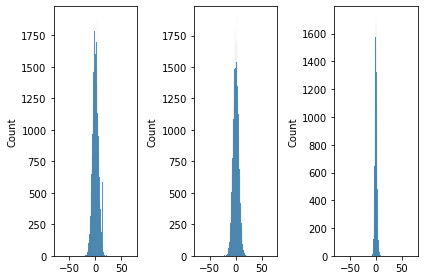

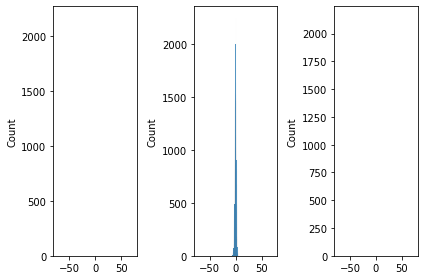

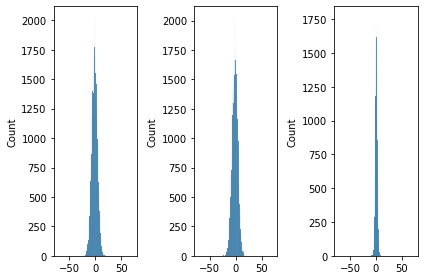

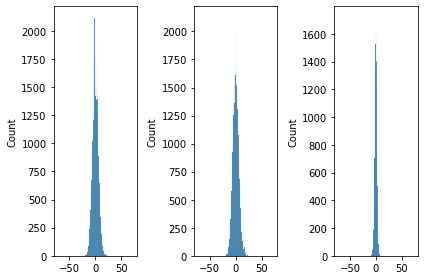

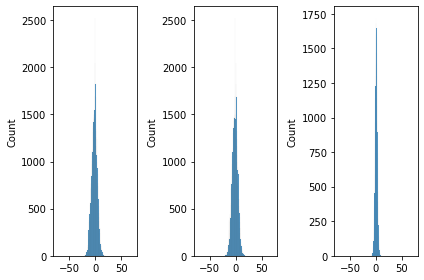

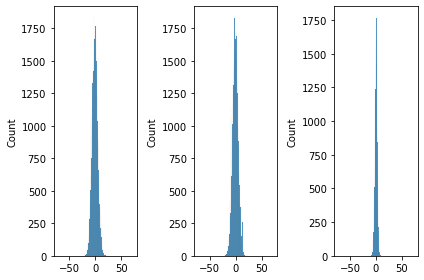

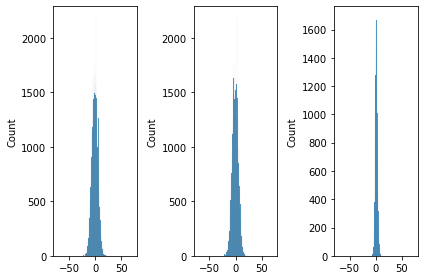

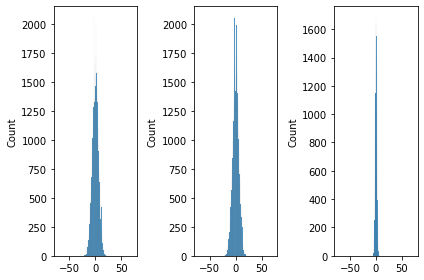

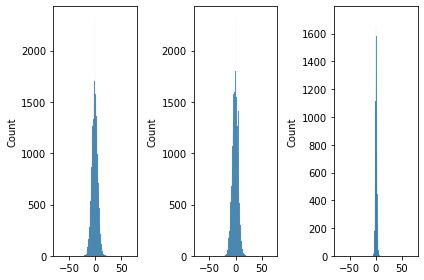

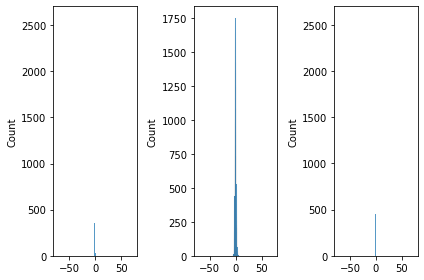

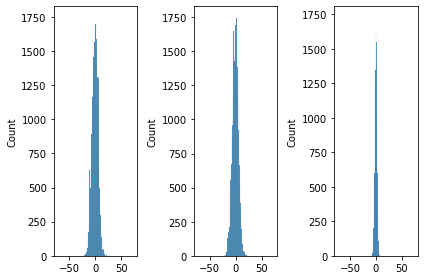

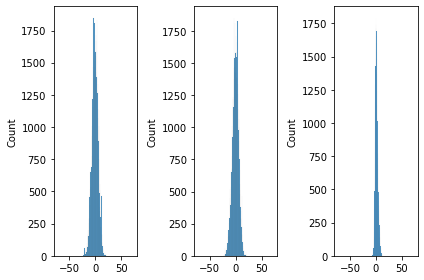

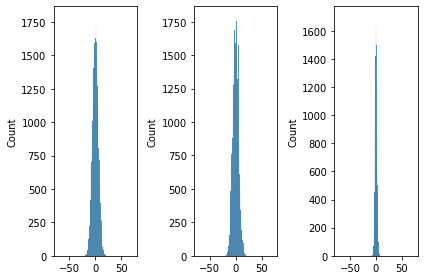

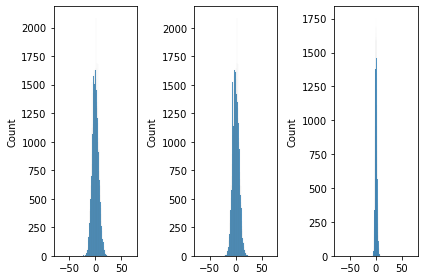

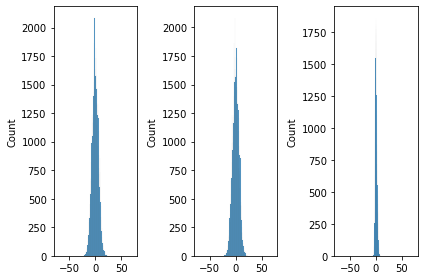

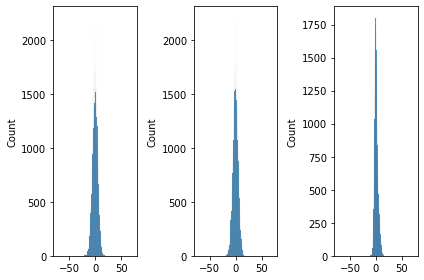

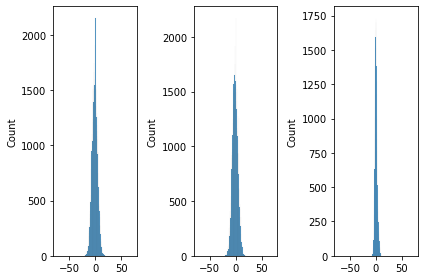

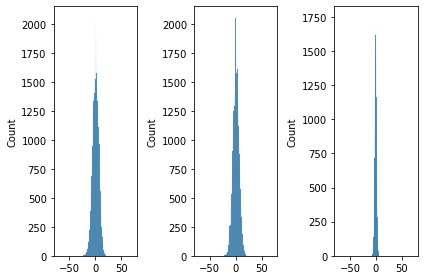

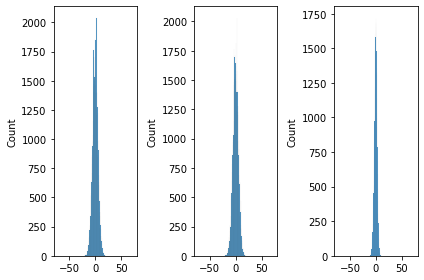

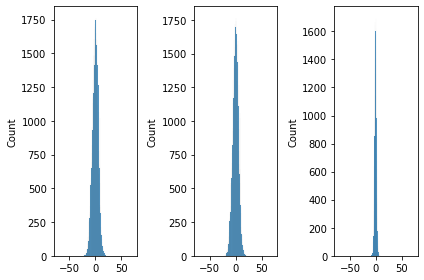

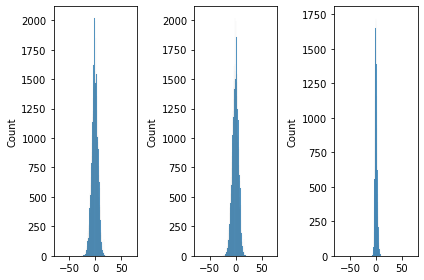

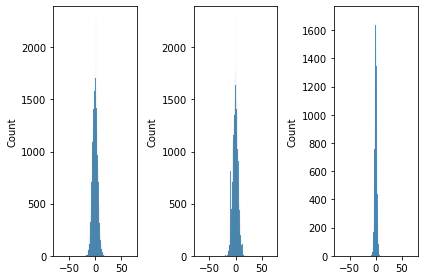

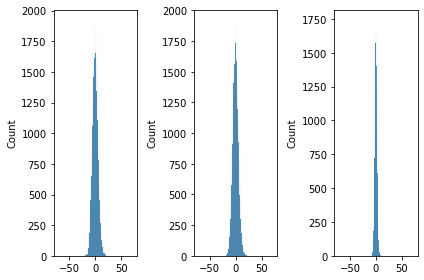

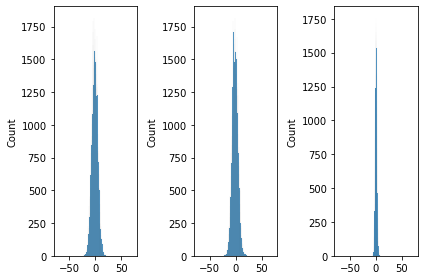

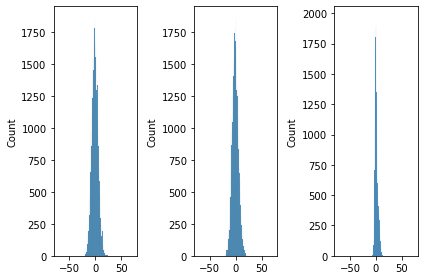

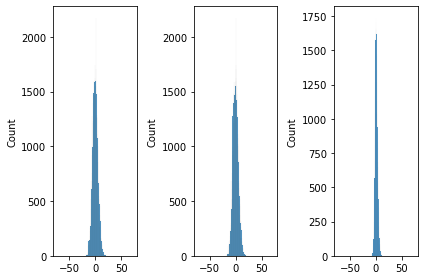

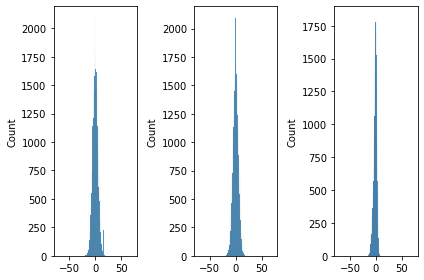

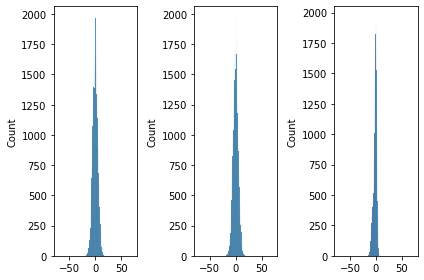

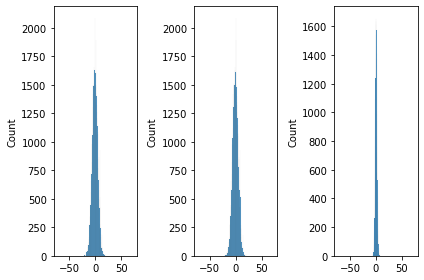

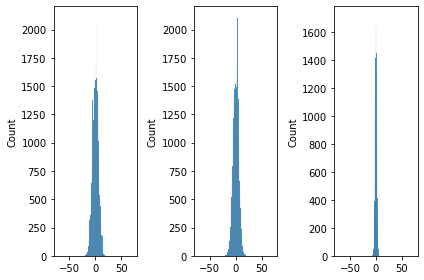

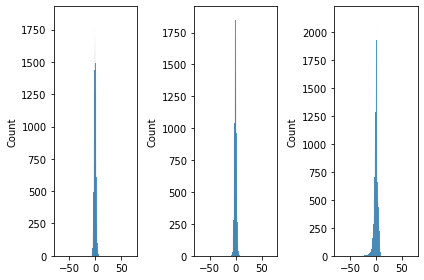

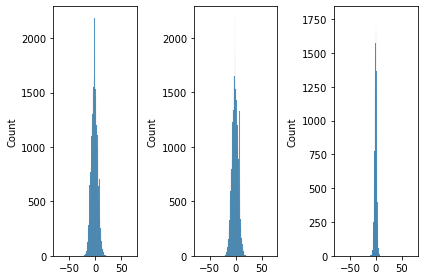

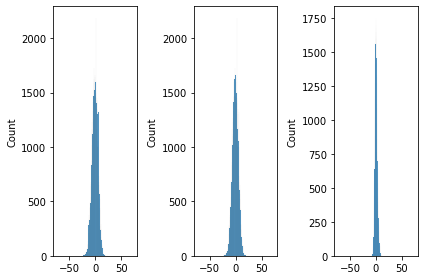

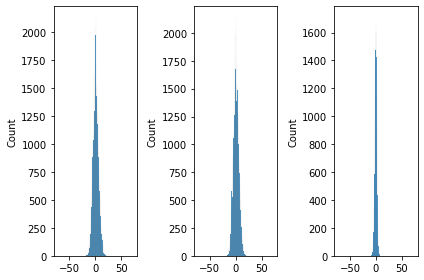

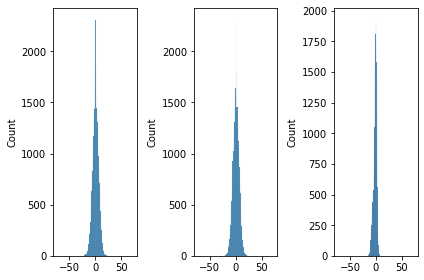

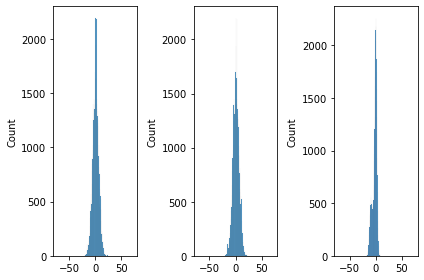

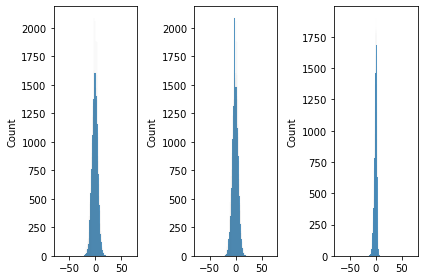

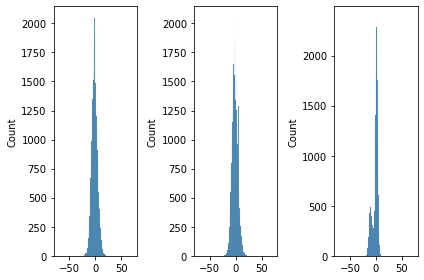

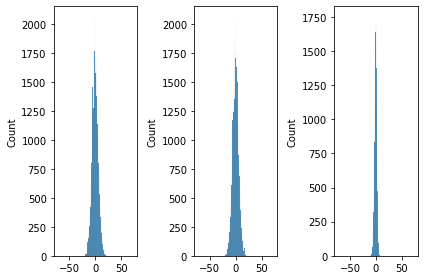

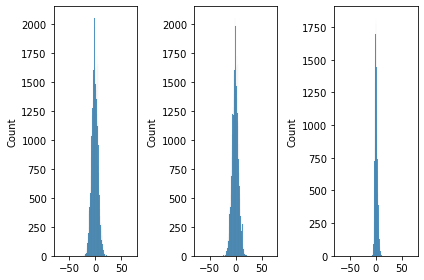

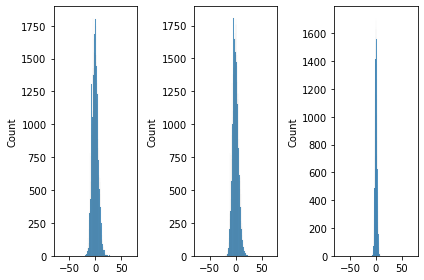

In [14]:
for i in range(50):
    figs, axes = plt.subplots(1, 3)
    for ax in axes:
        ax.set_xlim(-80, 80)
    plot = sb.histplot(latent_joint.X[:, i], ax=axes[0])
    plot = sb.histplot(latent_tcr.X[:, i], ax=axes[1])
    plot = sb.histplot(latent_rna.X[:, i], ax=axes[2])
    plt.tight_layout()
    plt.show()
    

In [13]:
# plotting function for latent spaces
def plot_umaps(adata, n_neighbors=15, min_dist=0.5, title=''):
    print(title)
    adata_tmp = adata.copy()
    sc.pp.neighbors(adata_tmp, n_neighbors=n_neighbors, random_state=42, use_rep='X')
    sc.tl.umap(adata_tmp, min_dist=min_dist, random_state=42)

    groups = ['full_clustering', 'clonotype']
    figs, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, col in enumerate(groups):
        if col == 'clonotype':
            ax = sc.pl.umap(adata_tmp, color=col, title=None, color_map=sb.color_palette("viridis", as_cmap=True), 
                            show=False, ax=axes[i])
        else:
            ax = sc.pl.umap(adata_tmp, color=col, title=None, show=False, ax=axes[i])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(None)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

joint


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


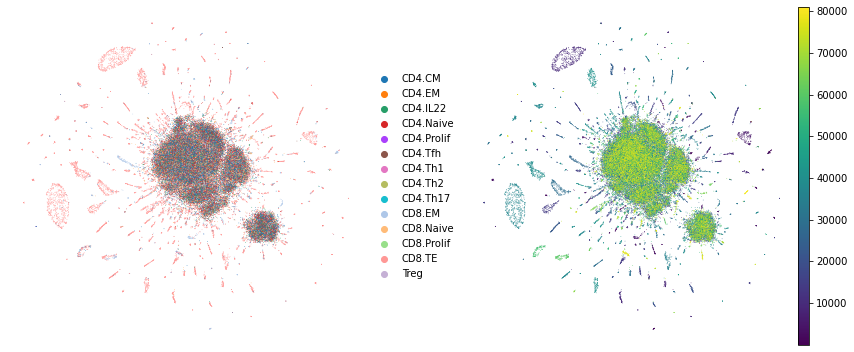

tcr


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


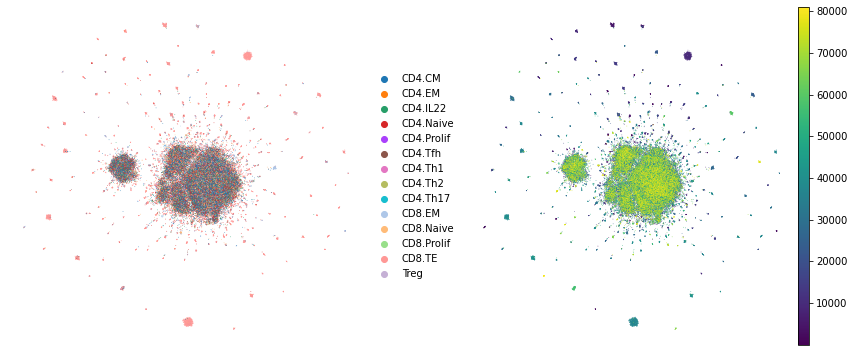

rna


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


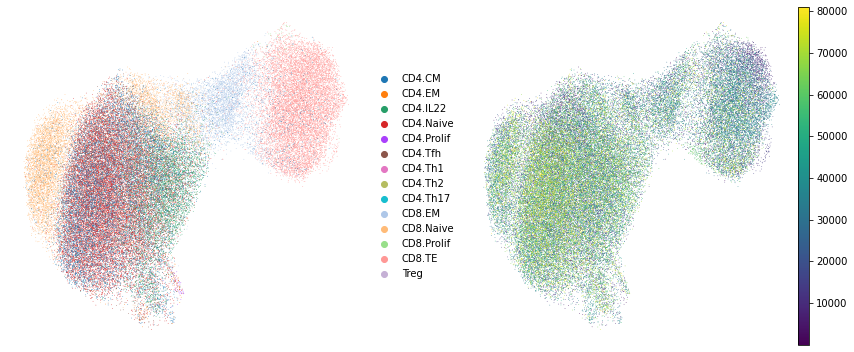

In [16]:
for name, x in lats.items():
    plot_umaps(x, title=name)

joint - weights: 1


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


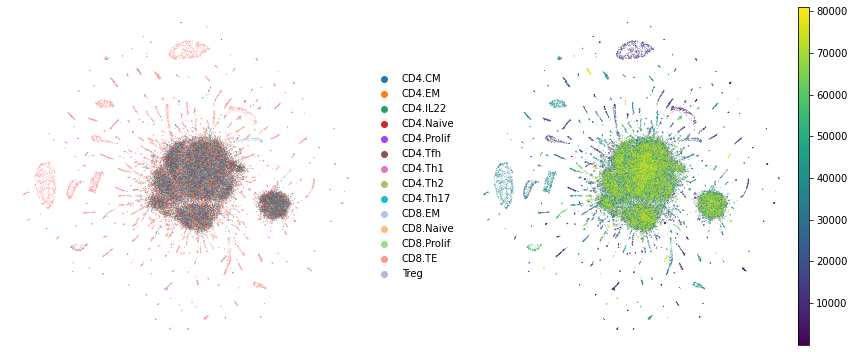

joint - weights: 50


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


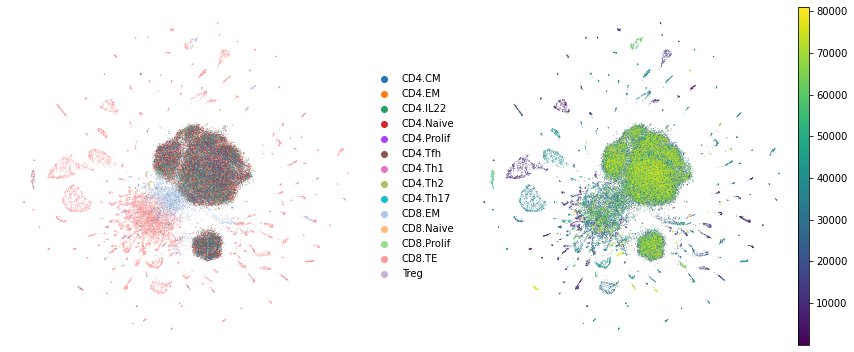

joint - weights: 100


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


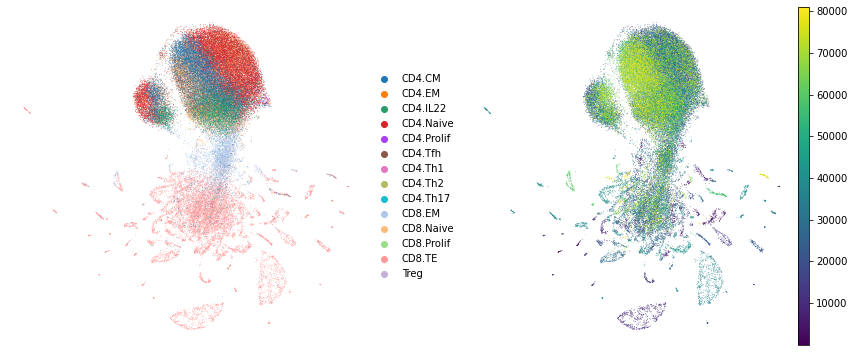

joint - weights: 150


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


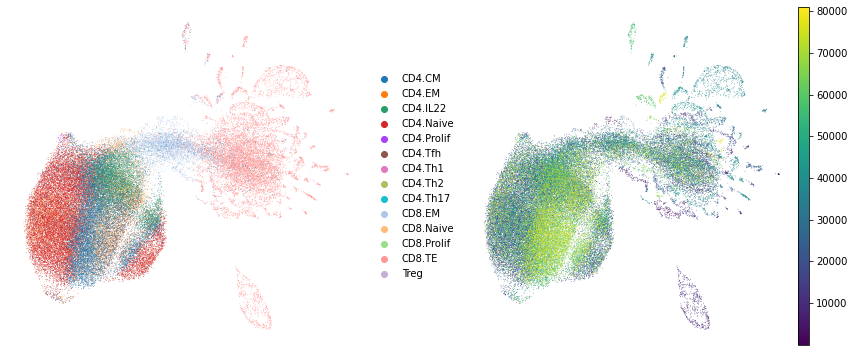

joint - weights: 200


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


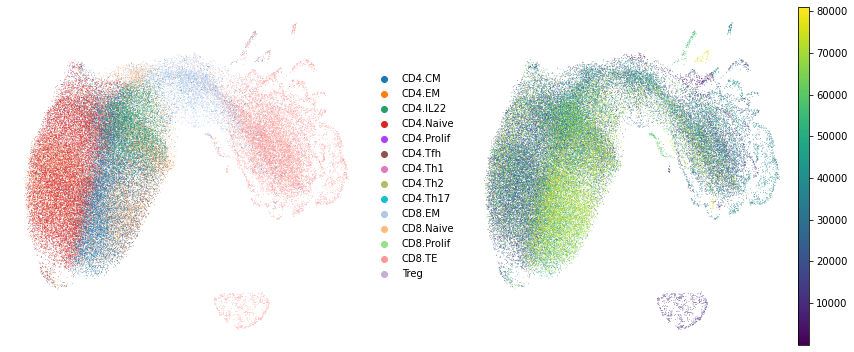

joint - weights: 500


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


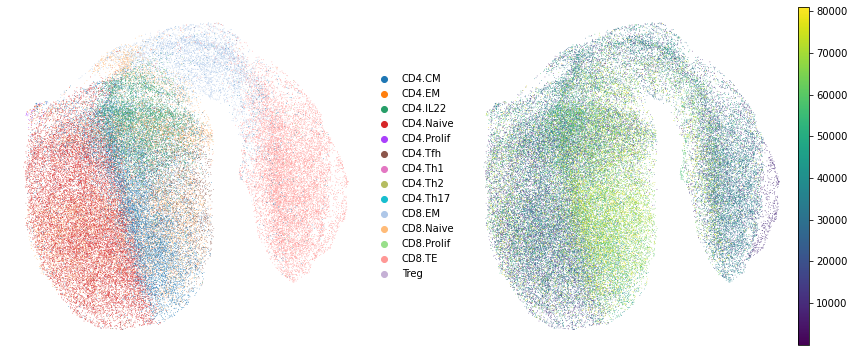

In [17]:
for weight in [1, 50, 100, 150, 200, 500]:
    trained_model.model.rna_priority = weight
    latent_mix = get_latent_space(data_train, modality=2)
    latent_mix.obs['clonotype'] = [x.numpy().tolist() for x in latent_mix.obs['clonotype']]
    plot_umaps(latent_mix, title=f'joint - weights: {weight}')

# Comparision vs Unimodal

In [3]:
path_rna = '../saved_models/test/poe_haniffa/haniffa_rna_zdim_cond_patient_id_best_rec_model.pt'
path_tcr = '../saved_models/test/poe_haniffa/haniffa_tcr_zdim_cond_patient_id_best_rec_model.pt'

In [4]:
def load_model(path_model, model_type):
    model_file = torch.load(path_model)
    params = model_file['params']
    model = tcr.utils_training.init_model(params, model_type=model_type, adata=data_full, dataset_name='haniffa', conditional='patient_id')
    model.load(path_model)
    return model

In [8]:
model_rna = load_model(path_rna, 'RNA')
model_tcr = load_model(path_tcr, 'TCR')

RNA


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


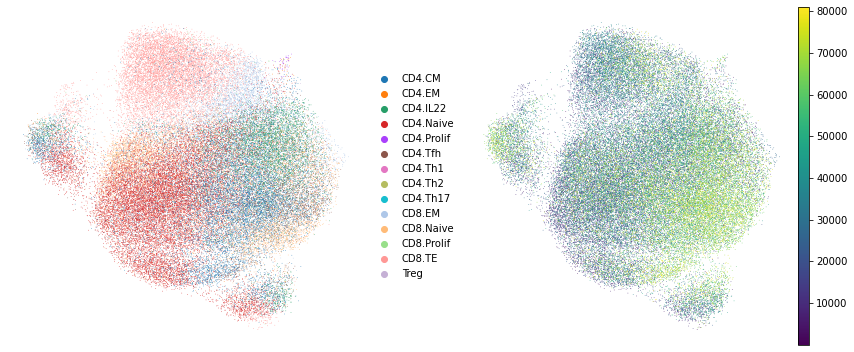

TCR


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


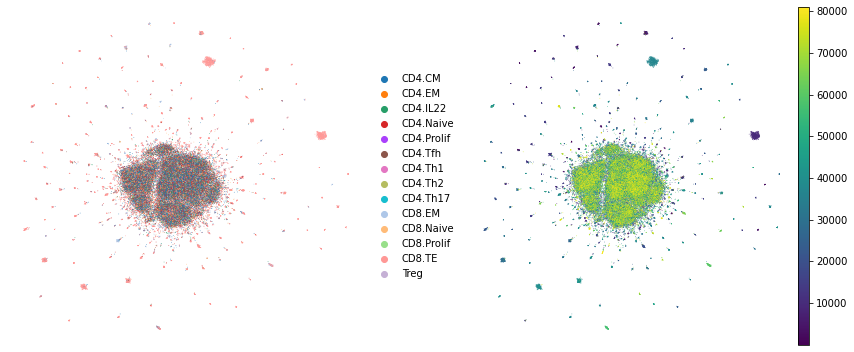

In [16]:
latent_model_rna = model_rna.get_latent([data_train], batch_size=1024, device='cuda', 
                                        metadata=['full_clustering', 'clonotype'])
latent_model_rna.obs['clonotype'] = [x.numpy().tolist() for x in latent_model_rna.obs['clonotype']]
plot_umaps(latent_model_rna, title='RNA')


latent_model_tcr = model_tcr.get_latent([data_train], batch_size=1024, device='cuda',
                                        metadata=['full_clustering', 'clonotype'])
latent_model_tcr.obs['clonotype'] = [x.numpy().tolist() for x in latent_model_tcr.obs['clonotype']]
plot_umaps(latent_model_tcr, title='TCR')

joint - weights: 1


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


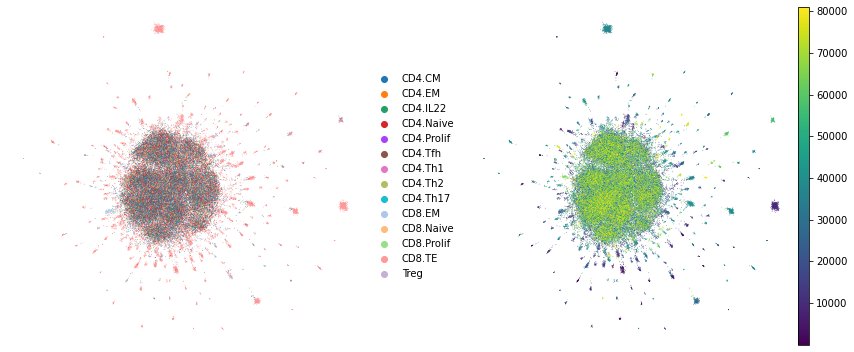

joint - weights: 3


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


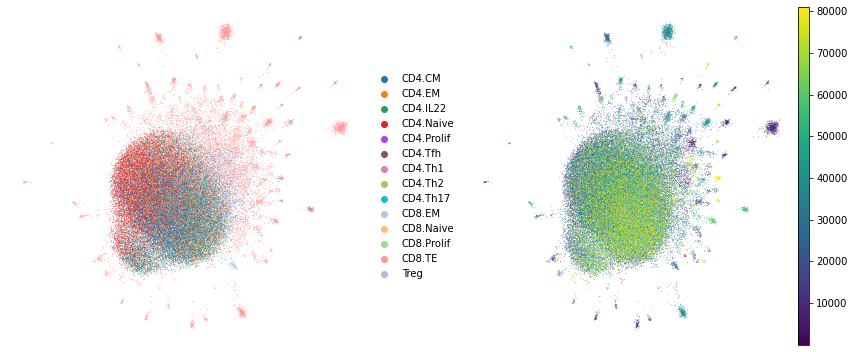

joint - weights: 5


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


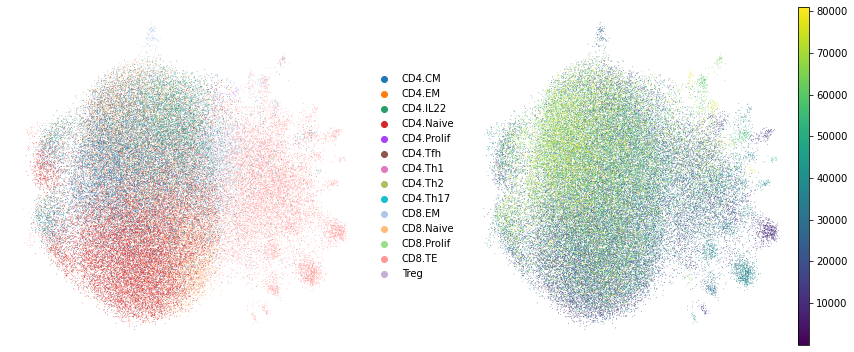

joint - weights: 7


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


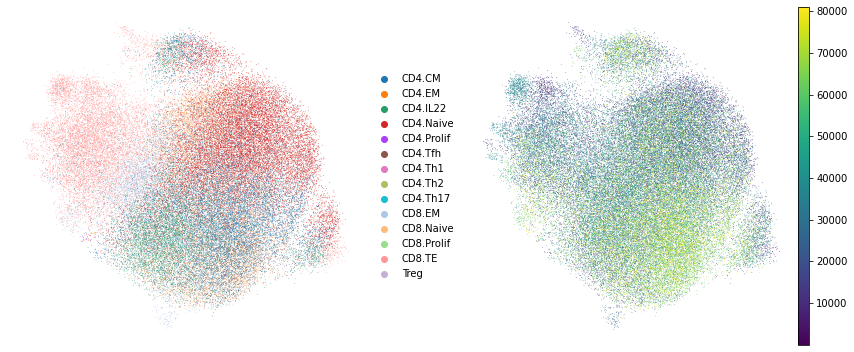

joint - weights: 9


... storing 'dataset' as categorical
... storing 'full_clustering' as categorical


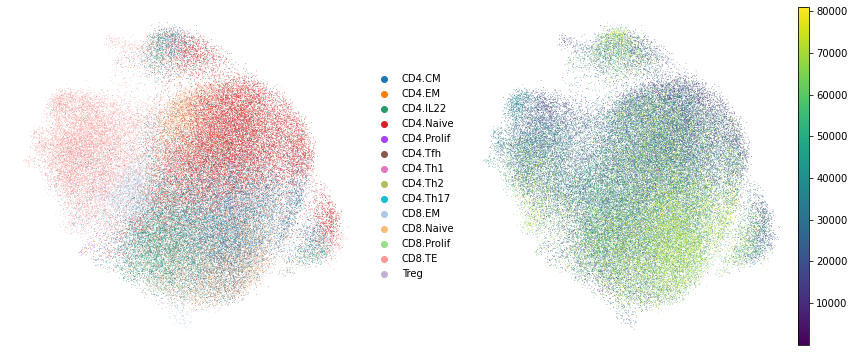

In [23]:
for weight in range(1, 10, 2):
    x_joint = latent_model_tcr.X + weight * latent_model_rna.X
    latent_mix = latent_model_rna.copy()
    latent_mix.X = x_joint
    plot_umaps(latent_mix, title=f'joint - weights: {weight}')